# Homework 7: Machine Learning in Physics
## Mengdi Wang
Here we will be training a neural network to solve Burger's Equation that is a convective-diffusion PDE that appears in various physical systems.  It reads as
\begin{equation}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} - \nu \frac{\partial^2 u}{\partial x^2} = 0,
\quad
x \in [-1, 1],
\quad
t \in [0, 1]
\end{equation}

* **Initial conditions:** $u(0,x) = -\sin(\pi x)$
* Periodic boundary conditions

*Note:* I used [black](https://github.com/psf/black) to auto-format my code, so some of its decisions are wonky but at least it's consistent!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import copy

### Class to hold the model data, i.e. training and/or testing datasets

In [2]:
class ModelData(object):
    """
    Input/output data for the neural network because the example NN code shown in class had the same structure
    Usage: obj = ModelData(x,y)
    """

    def __init__(self, x, y):
        self.x = x
        self.y = y

### Solver for the Burger Equation
Fill in the missing code in the PDE solver to use the FTUS (forward-time upwind-scheme) method.  We used this method in HW4.

In [3]:
class BurgerSolver(object):
    def __init__(self, n=1000, nu=0.1, tend=1, cfl=0.01):
        """
        Initialization of all parameters, solution arrays, and set the initial conditions
        Inputs: n :: Number of x points
                nu :: diffusion coefficient
                tend :: stop time
                cfl :: Courant factor controlling the timestep
        """
        self.L = 2.0
        self.n = n
        self.dx = self.L / self.n
        self.x = np.linspace(0, self.L, self.n) - self.L / 2  # Centered on zero
        self.nu = nu
        self.t = 0.0
        self.tend = tend
        self.dt = cfl * self.dx
        print(self.dt)
        self.Nt = int(self.tend / self.dt)
        self.u = np.empty((self.n, self.Nt + 1))
        self.dudx = np.zeros((self.n, self.Nt + 1))
        self.iter = 0
        self.seed = None

        # Initial conditions
        self.u[:, 0] = -np.sin(np.pi * self.x)

    def plot_one(self, iter=None, show=True, save=False):
        """
        Plot one solution at Iteration `iter`.  You can either `show` it or `save` it.
        Default is to plot the final solution.
        """
        if iter == None:
            iter = self.iter  # last iteration
        fig, ax = plt.subplots()
        ax.plot(self.x, self.u[:, iter])
        ax.set_xlabel("x")
        ax.set_ylabel("u")
        ax.set_title(f"Time = {self.t:.4g} :: Iteration {iter}")
        if save:
            plt.savefig(f"burger-iter{iter:05d}.png")
        if show:
            plt.show()

    def plot_evo(self, show=True, save=False):
        """
        Plot all solutions as a space-time diagram.  You can either `show` it or `save` it.
        """
        fig, ax = plt.subplots(1, 1)
        im = ax.imshow(
            self.u,
            origin="lower",
            cmap="RdBu",
            extent=[0, self.tend, -self.L / 2, self.L / 2],
            aspect="auto",
        )
        ax.set_xlabel("Time")
        ax.set_ylabel("x")
        fig.colorbar(im, label="u")
        ax.set_title(f"Burger's Equation evolution")
        if save:
            plt.savefig(f"burger-iter{self.iter:05d}.png")
        if show:
            plt.show()

    def solve(self, pbar=True, verbose=False):
        """
        Numeric solver for the Burger equation.
        """
        # Pre-compute some quantities
        dx_inv = 1 / self.dx
        dtdx = self.dt * dx_inv
        dtdx2 = self.dt * dx_inv * dx_inv
        du = np.empty(self.n)
        if pbar and not verbose:
            print(
                "0|"
                + "-" * 25
                + "|"
                + "-" * 25
                + "|"
                + "-" * 25
                + "|"
                + "-" * 25
                + "|100"
            )
        while self.t < self.tend:
            u = self.u[:, self.iter]  # Just for conciseness
            dudx = self.dudx[:, self.iter]
            unew = u.copy()

            ### COMPLETE CODE HERE
            # FTUS solver.
            # self.u holds the solutions for all times.
            # u is the current solution.
            # unew is the future solution, which you need to compute with finite differencing.

            for i in range(1, self.n - 1):
                if u[i] > 0:
                    unew[i] = u[i] - dtdx * u[i] * (u[i] - u[i - 1]) 
                    + self.nu * dtdx * ( dudx[i] - dudx[i - 1] )
                else:
                    unew[i] = u[i] - dtdx * u[i] * (u[i + 1] - u[i]) 
                    + self.nu * dtdx * ( dudx[i + 1] - dudx[i] )

            self.u[:, self.iter + 1] = unew

            # Use center differencing to compute du/dx from new solution.
            # du/dx boundaries are already zero, so only modify [1:-1]
            #self.dudx[1:-1, self.iter + 1] = (unew[2:] - unew[:-2]) * dx_inv
            # Also use FTUS to compute du/dx
            for i in range(1, self.n - 1):
                if unew[i] > 0:
                    self.dudx[i, self.iter + 1] = (unew[i] - unew[i - 1]) * dx_inv
                else:
                    self.dudx[i, self.iter + 1] = (unew[i + 1] - unew[i]) * dx_inv
            self.iter += 1
            self.t += self.dt
            if verbose:
                print(
                    f"Time = {self.t} seconds, mean/min/max = {unew.mean()} / {unew.min()} / {unew.max()}"
                )
            elif pbar:
                print("  " + "=" * int(self.iter / self.Nt * 100) + ">", end="\r")
            if self.iter == self.Nt:
                break

    def random_sample(self, N, seed=None):
        """
        Returns a ModelData object with random samples of u(x,t), x, t from our solution.
        Used in this notebook to train a neural network below.
        """
        if self.iter == 0:
            print("Calculation not performed yet. Returning nothing.")
            return None
        # Initialize RNG if not done already
        if self.seed == None:
            if seed != None:
                self.seed = seed
            else:
                self.seed = int(time.time())
            np.random.seed(self.seed)
        randx = np.random.randint(1, self.n - 1, size=N)
        randt = np.random.randint(0, self.Nt, size=N)
        input = np.array([self.x[randx], self.dt * randt])
        output = np.atleast_2d(self.u[randx, randt])
        obj = ModelData(input, output)
        return obj

In [4]:
bs = BurgerSolver(tend=1, n=1000, nu=0.01, cfl=0.05)
bs.solve()

0.0001
0|-------------------------|-------------------------|-------------------------|-------------------------|100


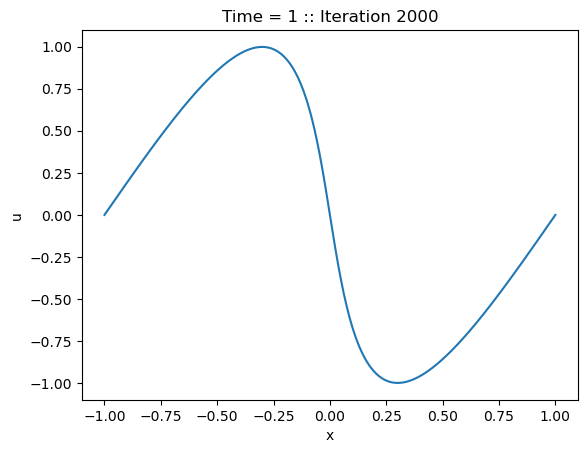

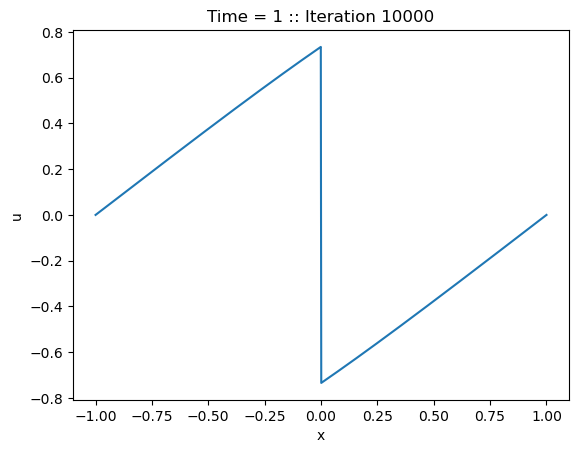

In [5]:
bs.plot_one(int(0.2 / bs.dt))
bs.plot_one()

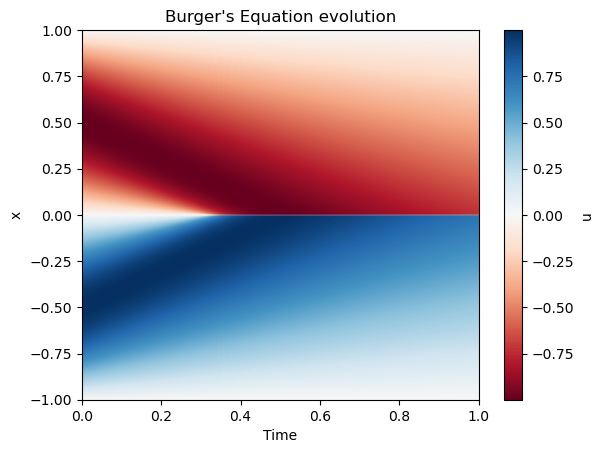

In [6]:
bs.plot_evo()

The above space-time diagram is our dataset from which we will sample data points at random values of (x,t) that will be the inputs into our neural network.

## Neural Network class for a single hidden layer
You'll need to modify several parts of the code below, marked by `COMPLETE HERE`.

In [16]:
class NeuralNetwork(object):
    """
    A neural network class with a single hidden layer.
    """

    def __init__(
        self,
        solver,
        num_training_unique=1000,
        n_epochs=10,
        learning_rate=0.1,
        regularization_rate=0.05,
        hidden_layer_size=2,
    ):
        """
        Initialization routine for parameters, training data, and NN weights (matrices)
        Inputs:
        * solver :: PDE solver with a `random_sample` routine that returns a ModelData object.
                    In HW7, it'd be a BurgerSolver object after you solve the system.
        * num_training_unique :: Training dataset size
        * n_epochs :: Number of training epochs, each randomly selecting `num_training_unique` inputs
        * learning_rate :: Factor that softens the gradient descent during minimization
        * regularization_rate :: Factor that controls how much the PDE residual is weighted (if used) in the loss function
        * hidden_layer_size :: Number of nodes in the single hidden layer
        """

        self.solver = solver
        self.num_training_unique = num_training_unique
        self.n_epochs = n_epochs

        self.train_set = self.solver.random_sample(self.num_training_unique)
        self.normalize(set_limits=True)
        self.set_boundary_points()
        # learning rate
        self.eta = learning_rate
        self.lam = regularization_rate

        # we get the size of the layers from the length of the input
        # and output
        model = self.train_set

        # the number of nodes/neurons on the output layer
        self.m = model.y.shape[0]

        # the number of nodes/neurons on the input layer
        self.n = model.x.shape[0]

        # the number of nodes/neurons on the hidden layer
        self.k = hidden_layer_size

        # we will initialize the weights with Gaussian normal random
        # numbers centered on 0 with a width of 1/sqrt(n), where n is
        # the length of the input state

        # A is the set of weights between the hidden layer and output layer
        self.A = np.random.normal(0.0, 1.0 / np.sqrt(self.k), (self.m, self.k))

        # B is the set of weights between the input layer and hidden layer
        self.B = np.random.normal(0.0, 1.0 / np.sqrt(self.n), (self.k, self.n))

    def normalize(self, model=None, set_limits=False):
        """
        Training NNs typically work best when the inputs and outputs are normalized.
        """
        if set_limits:
            self.xmin = self.train_set.x.min(1)
            self.xmax = self.train_set.x.max(1)
            self.ymin = self.train_set.y.min()
            self.ymax = self.train_set.y.max()
        if model == None:
            self.train_set.x = (self.train_set.x - self.xmin[:, None]) / (
                self.xmax[:, None] - self.xmin[:, None]
            )
            self.train_set.y = (self.train_set.y - self.ymin) / (self.ymax - self.ymin)
        else:
            _model = copy.deepcopy(model)
            _model.x = (_model.x - self.xmin[:, None]) / (
                self.xmax[:, None] - self.xmin[:, None]
            )
            _model.y = (_model.y - self.ymin) / (self.ymax - self.ymin)
            return _model

    def denormalize(self, data):
        """
        This function is used when we need to remove the normalization factors when providing predictions.
        """
        data = data * (self.ymax - self.ymin) + self.ymin
        return data

    def set_activation(self, gtype="sigmoid"):
        if gtype not in ["sigmoid", "relu", "tanh", "leaky_relu"]:
            raise RuntimeError(f"Activation function {gtype} unknown.")
        self.gtype = gtype

    def g(self, p, type="sigmoid"):
        """
        our activation function that operates on the hidden layer.
        NOTE: AFAIK in this code, sigmoid is the only function that works in Burger's Equation for 1 hidden layer.
        """
        if self.gtype == "sigmoid":
            return 1.0 / (1.0 + np.exp(-p))
        elif self.gtype == "relu":
            return np.maximum(0, p)
        elif self.gtype == "leaky_relu":
            return np.maximum(0.1 * p, p)
        elif self.gtype == "tanh":
            return np.tanh(p)
        else:
            raise RuntimeError(f"Activation function {self.gtype} unknown.")

    def set_boundary_points(self, N=50):
        """
        Sets points for the initial and boundary conditions so we can use them in the loss function.
        """
        self.bc_x = np.linspace(self.xmin[0], self.xmax[0], N)
        self.bc_t = np.linspace(self.xmin[1], self.xmax[1], N)

        ###
        ### COMPLETE HERE.  Set the analytic functions that describe the initial and boundary conditions.
        ###
        self.initial_fn = lambda x: -np.sin(np.pi * x)
        self.boundary_fn = lambda x: 0 * x

    def return_ic_loss(self):
        """
        Returns the mean squared error between the predictions and analytic initial condition.
        """
        ###
        ### COMPLETE HERE.
        ###

        # compute initial condition for the N points using current network
        xx = np.zeros([2, self.bc_x.shape[0]])
        xx[0, :] = self.bc_x
        nn = self.bc_x.shape
        z = self.predict(ModelData(xx, np.zeros(nn)))
        return (np.linalg.norm(z - self.initial_fn(self.bc_x))) / nn
        # return 0.0

    def return_bc_loss(self):
        """
        Returns the mean squared error between the predictions and analytic boundary condition.
        """
        ###
        ### COMPLETE HERE.
        ###

        # compute boundary condition for the N points using current network
        xx = np.zeros([2, self.bc_t.shape[0]])
        xx[1, :] = self.bc_t
        nn = self.bc_t.shape
        z = self.predict(ModelData(xx, np.zeros(nn)))
        return (np.linalg.norm(z - self.boundary_fn(self.bc_t))) / nn
        # return 0.0

    def return_deriv(self, x0, t0, dx=1e-3, dt=1e-3):
        """
        Given a (x,t) value, this function retuns the following partial derivatives so we can compute the residual from Burger's Equation.
        Inputs:
        * x0 :: position to evaluate derivatives
        * t0 :: time to evaluate derivatives
        * dx :: distance between adjacent points when computing spatial derivatives
        * dt :: time between adjacent points when computing time derivatives

        Returns:
        * u_t :: du/dt
        * u_x :: du/dx
        * u_xx :: d^2 u/dx^2
        """
        ###
        ### COMPLETE HERE
        ###
        # Use the NN to predict the u-values at nearby points and use central differencing to compute all the needed derivatives

        # compuete dudx, dudt, du2dx2 with central difference
        dudx = (self.predict(ModelData(np.array([x0 + dx / 2, t0]), 0)) - self.predict(ModelData(np.array([x0 - dx / 2, t0]), 0))) / dx
        dudt = (self.predict(ModelData(np.array([x0, t0 + dt / 2]), 0)) - self.predict(ModelData(np.array([x0, t0 - dt / 2]), 0))) / dx
        dudx_x1 = (self.predict(ModelData(np.array([x0, t0]), 0)) - self.predict(ModelData(np.array([x0 - dx, t0]), 0))) / dx
        dudx_x2 = (self.predict(ModelData(np.array([x0 + dx, t0]), 0)) - self.predict(ModelData(np.array([x0, t0]), 0))) / dx
        du2dx2 = (dudx_x2 - dudx_x1) / dx
        return dudt, dudx, du2dx2

    def return_res_loss(self, u, x, t):
        """
        Returns residual from Burger's equation: u_t + u*u_x - nu*u_xx = 0
        """
        u_t, u_x, u_xx = self.return_deriv(x, t)
        res = u_t + u * u_x - self.eta * u_xx
        return np.atleast_2d(res)

    def set_loss_function(self, fn=None, method="exact"):
        if fn is not None:
            self.loss = fn
        else:
            if method == "exact":
                self.loss = lambda x, y, z: z - y
            # Add your methods here or assign a function
            elif method == "exact+initial":
                self.loss = lambda x, y, z: z - y + self.return_ic_loss()
            elif method == "exact+initial+boundary":
                self.loss = (
                    lambda x, y, z: z - y
                    + self.return_ic_loss()
                    + self.return_bc_loss()
                )
            elif method == "res+initial+boundary":
                self.loss = (
                    lambda x, y, z: z - y
                    + self.lam * self.return_res_loss(y[0], x[0], x[1])
                    + self.return_ic_loss()
                    + self.return_bc_loss()
                )
            else:
                raise RuntimeError(f"Method {method} not recognized.")

    def train(self):
        """
        Train the neural network by doing gradient descent with back
        propagation to set the matrix elements in B (the weights
        between the input and hidden layer) and A (the weights between
        the hidden layer and output layer)
        """
        all_loss = []
        print(
            "0|" + "-" * 25 + "|" + "-" * 25 + "|" + "-" * 25 + "|" + "-" * 25 + "|100"
        )
        for iepoch in range(self.n_epochs):
            # print(f"epoch {i+1} of {self.n_epochs}")
            loss = 0.0
            for _ in range(self.num_training_unique):
                ii = np.random.randint(0, self.num_training_unique)

                # Convert into 1D
                x = self.train_set.x[:, ii].reshape(self.n, 1)
                y = self.train_set.y[:, ii].reshape(self.m, 1)


                z_tilde = self.g(self.B @ x)
                z = self.g(self.A @ z_tilde)

                e = self.loss(x, y, z)
                loss += (e**2).sum()
                if np.isinf(loss):
                    raise RuntimeError(
                        f"Infinite loss function. Epoch {iepoch}, e = {e}, x,y = {x},{y}"
                    )
                e_tilde = self.A.T @ e

                dA = -2 * self.eta * e * z * (1 - z) @ z_tilde.T
                dB = -2 * self.eta * e_tilde * z_tilde * (1 - z_tilde) @ x.T

                self.A[:, :] += dA
                self.B[:, :] += dB

            print("  " + "=" * int(iepoch / self.n_epochs * 100) + ">", end="\r")
            all_loss.append(loss)
        return np.array(all_loss) / self.num_training_unique

    def predict(self, model):
        """predict the outcome using our trained matrix A"""
        nmodel = self.normalize(model=model)
        y = self.g(self.A @ (self.g(self.B @ nmodel.x)))
        return self.denormalize(y)

0|-------------------------|-------------------------|-------------------------|-------------------------|100
0|-------------------------|-------------------------|-------------------------|-------------------------|100
0|-------------------------|-------------------------|-------------------------|-------------------------|100
0|-------------------------|-------------------------|-------------------------|-------------------------|100
0|-------------------------|-------------------------|-------------------------|-------------------------|100


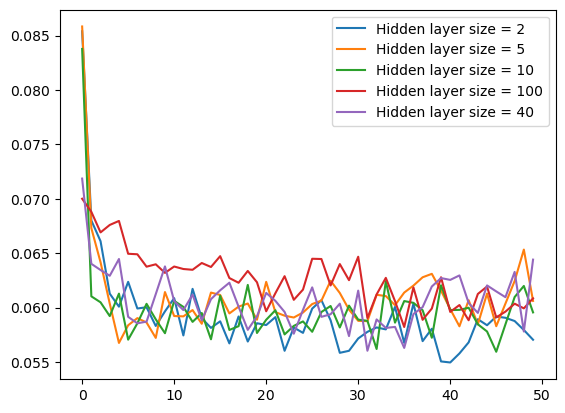

In [17]:
np.random.seed(42)
partb_loss = {}
for k in [2,5,10,100,40]:
    nn = NeuralNetwork(
        bs, num_training_unique=2000, n_epochs=50, hidden_layer_size=k, learning_rate=0.1
    )
    nn.set_activation("sigmoid")
    nn.set_loss_function(method="exact")
    loss = nn.train()
    partb_loss[k] = loss
    plt.plot(loss, label=f"Hidden layer size = {k}")
plt.legend()
plt.show()

## (b)

Here we sample $10000$ points using the `random_sample()` function of the Burgers simulator. We plot both the ground truth and predicted velocities by different colors of the dots. The first and second figures are the ground truth and the NN predicted values respectively, and the third figure is the absolute error

$$
\frac{|u-\hat{u}|}{||u||_{\infty}}
$$

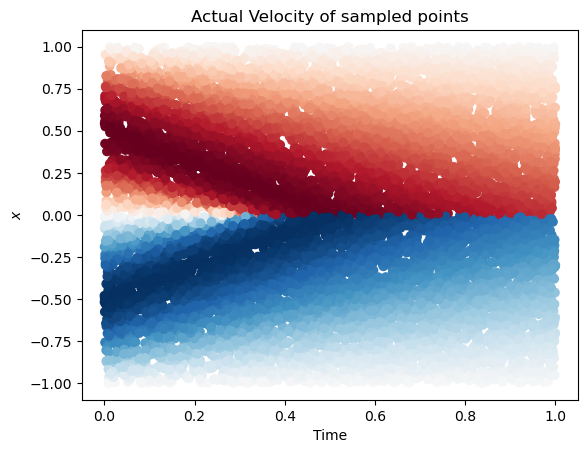

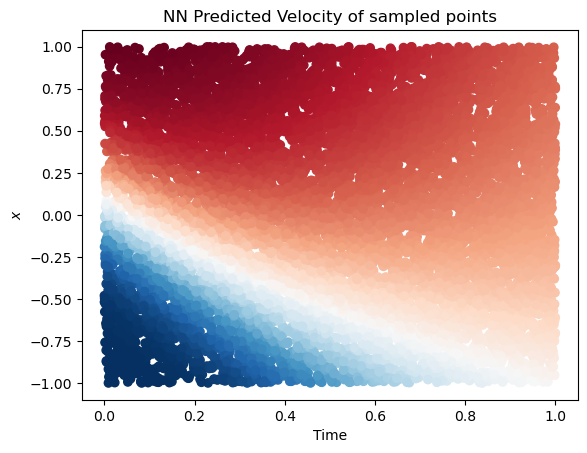

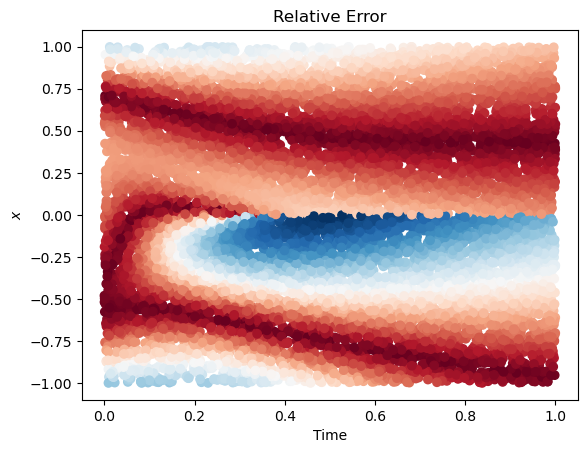

In [18]:
# Note that now the nn is trained with k=40

predict_model = bs.random_sample(10000)
predict_nn = nn.predict(predict_model)
plt.title("Actual Velocity of sampled points")
plt.xlabel("Time")
plt.ylabel(r"$x$")
plt.scatter(predict_model.x[1], predict_model.x[0], c=predict_model.y, cmap="RdBu")
plt.show()
plt.title("NN Predicted Velocity of sampled points")
plt.xlabel("Time")
plt.ylabel(r"$x$")
plt.scatter(predict_model.x[1], predict_model.x[0], c=predict_nn, cmap="RdBu")
plt.show()

# Calculate the absolute difference
abs_err = np.abs(predict_model.y - predict_nn)
# Calculate the relative difference
rel_err = abs_err / predict_model.y.max()
plt.title("Relative Error")
plt.xlabel("Time")
plt.ylabel(r"$x$")
plt.scatter(predict_model.x[1], predict_model.x[0], c=rel_err, cmap="RdBu")
plt.show()

## (c)

0|-------------------------|-------------------------|-------------------------|-------------------------|100


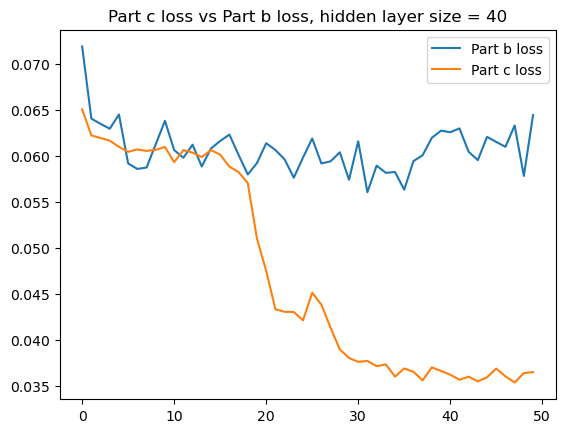

In [25]:
np.random.seed(42)
partc_nn = NeuralNetwork(
    bs, num_training_unique=10000, n_epochs=50, hidden_layer_size=40, learning_rate=0.1
)
partc_nn.set_activation("sigmoid")
partc_nn.set_loss_function(method="exact+initial+boundary")
loss_c = partc_nn.train()
plt.title("Part c loss vs Part b loss, hidden layer size = 40")
plt.plot(partb_loss[40], label=f"Part b loss")
plt.plot(loss_c, label=f"Part c loss")
plt.legend()
plt.show()

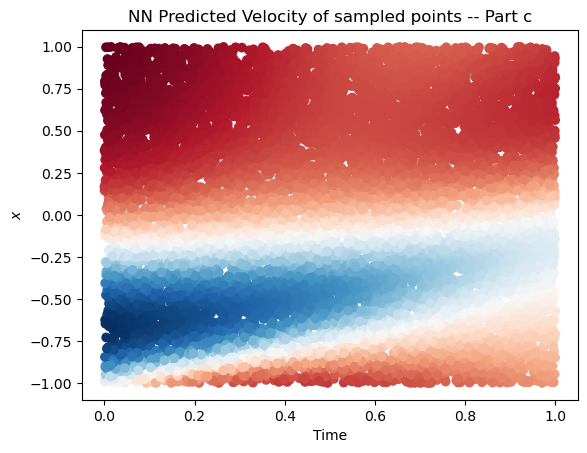

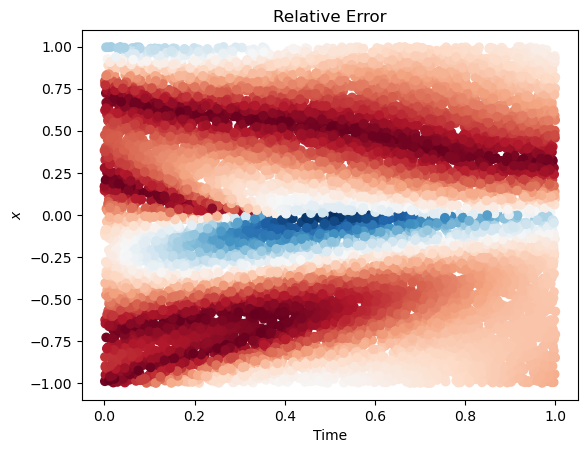

In [27]:
predict_model = bs.random_sample(10000)
predict_c = partc_nn.predict(predict_model)

plt.title("NN Predicted Velocity of sampled points -- Part c")
plt.xlabel("Time")
plt.ylabel(r"$x$")
plt.scatter(predict_model.x[1], predict_model.x[0], c=predict_c, cmap="RdBu")
plt.show()

# Calculate the absolute difference
abs_err = np.abs(predict_model.y - predict_c)
# Calculate the relative difference
rel_err = abs_err / predict_model.y.max()
plt.title("Relative Error")
plt.xlabel("Time")
plt.ylabel(r"$x$")
plt.scatter(predict_model.x[1], predict_model.x[0], c=rel_err, cmap="RdBu")
plt.show()

0|-------------------------|-------------------------|-------------------------|-------------------------|100


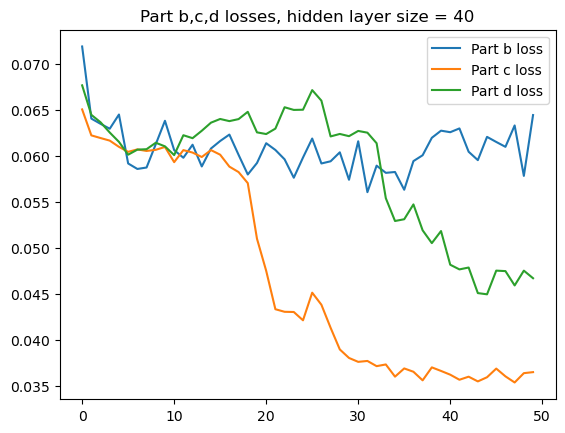

In [28]:
np.random.seed(42)
partd_nn = NeuralNetwork(
    bs, num_training_unique=10000, n_epochs=50, hidden_layer_size=40, learning_rate=0.1
)
partd_nn.set_activation("sigmoid")
partd_nn.set_loss_function(method="res+initial+boundary")
loss_d = partd_nn.train()
plt.title("Part b,c,d losses, hidden layer size = 40")
plt.plot(partb_loss[40], label=f"Part b loss")
plt.plot(loss_c, label=f"Part c loss")
plt.plot(loss_d, label=f"Part d loss")
plt.legend()
plt.show()